In [144]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats_basic import normaltest
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

from drive.MyDrive.Kaggle_TPS_0822.src import functions

import warnings
warnings.filterwarnings("ignore")

In [38]:
CFG = yaml.load(open('drive/MyDrive/Kaggle_TPS_0822/src/config.YAML', 'rb'))

functions.set_seed(CFG['SEED'])

pd.set_option('display.max_rows', CFG['NROWS'])
pd.set_option('display.max_columns', CFG['NCOLS'])

data = pd.read_csv(CFG['DATAPATH'] + 'imputed_data.csv', index_col='id')

In [11]:
def prepro_v1(data):
    data = pd.concat([pd.get_dummies(data[['attribute_0', 'attribute_1']]), data], axis=1).drop(['attribute_0', 'attribute_1'], axis=1)
    data.drop([f'measurement_{i}' for i in range(3, 17)], axis=1, inplace=True)

    data['loading'] = PowerTransformer().fit_transform(data['loading'].values.reshape(-1, 1))

    scaler_list = data[cont_feats.tolist() + ['attribute_2', 'attribute_3', 'area']].drop('failure', axis=1).columns.tolist()
    data[scaler_list] = StandardScaler().fit_transform(data[scaler_list])
    return data

data = prepro_v1(data)

In [4]:
cat_feats, int_feats, cont_feats, _, _ = functions.get_feats(data)

In [19]:
train, test = data[data['failure'].notnull()], data[data['failure'].isna()]

In [41]:
def run_model(df):
    kf = GroupKFold(n_splits=5)
    train, test = df[df['failure'].notnull()], df[df['failure'].isna()]
    auc_list = []
    test_pred_list = []
    importance_list = []
    kf = GroupKFold(n_splits=5)   # grouped by product_code
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X=train, y=train['failure'], groups=train['product_code'])):
        X_tr = train.iloc[idx_tr].drop(['product_code', 'failure'], axis=1)
        X_va = train.iloc[idx_va].drop(['product_code', 'failure'], axis=1)
        y_tr = train.loc[idx_tr,'failure']
        y_va = train.loc[idx_va,'failure']

        lr = LogisticRegression()
        lr.fit(X_tr, y_tr)
        importance_list.append(lr.coef_.ravel())

        va_preds = lr.predict_proba(X_va)[:,1]
        score = roc_auc_score(y_va, va_preds)
        print(f"Fold {fold}: auc = {score:.5f}")
        auc_list.append(score)

        test_pred_list.append(lr.predict_proba(test.drop(['product_code', 'failure'], axis=1))[:,1])

    print(f'Average auc = {sum(auc_list) / len(auc_list):.5f}')
    print('')
    preds = sum(test_pred_list)/len(test_pred_list)

    return auc_list, test_pred_list, importance_list, preds   

In [50]:
auc_list, test_pred_list, importance_list, preds = run_model(data)

Fold 0: auc = 0.58573
Fold 1: auc = 0.58381
Fold 2: auc = 0.58894
Fold 3: auc = 0.59785
Fold 4: auc = 0.59433
Average auc = 0.59013



In [36]:
sub = pd.read_csv(CFG['SUBMISSIONS'] + 'sample_submission.csv', index_col='id')
sub['failure'] = preds
sub.to_csv(CFG['SUBMISSIONS'] + 'ohe_ss_nomeasures3-16.csv', index='id')

In [43]:
def plot_importances(importance_list, df):
    train, test = df[df['failure'].notnull()], df[df['failure'].isna()]

    importance_df = pd.DataFrame(np.array(importance_list).T, index=train.drop(['product_code', 'failure'], axis=1).columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = train.drop(['product_code', 'failure'], axis=1).columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('LogisticRegression feature importances')
    plt.show()

plot_importances(importance_list)

In [157]:
def prepro_v2(df):
    df = data.copy()
    df['attribute_0'], df['attribute_1'] = LabelEncoder().fit_transform(df['attribute_0']), LabelEncoder().fit_transform(df['attribute_1'])
    #df = pd.concat([pd.get_dummies(df[['attribute_0', 'attribute_1']], drop_first=True), df], axis=1).drop(['attribute_0', 'attribute_1'], axis=1)

    df['meas_3*5_na'] = df['measurement_3_na'] * df['measurement_5_na']
    # df['meas_3*5'] = df['measurement_3'] * df['measurement_5']
    df['loading'] = PowerTransformer().fit_transform(df['loading'].values.reshape(-1, 1))
    df['measurement_0'] = PowerTransformer().fit_transform(df['measurement_0'].values.reshape(-1, 1))
    df['measurement_1'] = PowerTransformer().fit_transform(df['measurement_1'].values.reshape(-1, 1))
    df['measurement_2'] = PowerTransformer().fit_transform(df['measurement_2'].values.reshape(-1, 1))

    scaler_list = df[cont_feats.tolist()].drop('failure', axis=1).columns.tolist()
    df[scaler_list] = StandardScaler().fit_transform(df[scaler_list])
    df.drop([f'measurement_{i}' for i in range(3, 17)], axis=1, inplace=True)
    df.drop(['attribute_0', 'attribute_1', 'area', 'attribute_2'],axis=1, inplace=True)
    return df

test = prepro_v2(data)

Fold 0: auc = 0.58638
Fold 1: auc = 0.58305
Fold 2: auc = 0.58874
Fold 3: auc = 0.59748
Fold 4: auc = 0.59448
Average auc = 0.59002



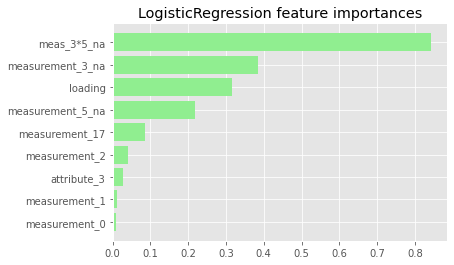

In [158]:
_, _, importance_list, preds = run_model(test)

plot_importances(importance_list, test)

In [156]:
sub = pd.read_csv(CFG['SUBMISSIONS'] + 'sample_submission.csv', index_col='id')
sub['failure'] = preds
sub.to_csv(CFG['SUBMISSIONS'] + 'le_ss_nomeasures3-16_noatt0-2_meas3*5_load+17_PT.csv', index='id')

In [18]:
# cat_feats, int_feats, cont_feats, _, _ = functions.get_feats(data)

# not_normal_list = []
# andy_nonormal = []
# for col in data[cont_feats]:
#     w, p = stats.shapiro(data[col])
#     skew, kurt = stats.skew(data[col]), stats.kurtosis(data[col])
#     nw, np = stats.normaltest(data[col])
#     astat, acrits, asig = stats.anderson(data[col], dist='norm') 
#     if p < 0.001:
#         not_normal_list.append(col)
#     if astat > 5:
#         andy_nonormal.append(col)
#     print('======='*10)
#     print(f'For Feature {col}: \nthe shapiro test statistic and p value are {w:.4f} and {p:.4f}, skew and kurtosis are {skew:.4f} and {kurt:.4f}, normaltest statistic and pvalue are {nw:.4f} and {np:.4f}, anderson statistic, crit values and significance are {astat}, {acrits} and {asig}')

For Feature loading: 
the shapiro test statistic and p value are 0.9547 and 0.0000, skew and kurtosis are 0.9595 and 1.6264, normaltest statistic and pvalue are 6985.1003 and 0.0000, anderson statistic, crit values and significance are 425.40578020492103, [0.576 0.656 0.787 0.918 1.092] and [15.  10.   5.   2.5  1. ]
For Feature measurement_0: 
the shapiro test statistic and p value are 0.9727 and 0.0000, skew and kurtosis are 0.5960 and 0.4581, normaltest statistic and pvalue are 2690.1507 and 0.0000, anderson statistic, crit values and significance are 287.20398817699606, [0.576 0.656 0.787 0.918 1.092] and [15.  10.   5.   2.5  1. ]
For Feature measurement_1: 
the shapiro test statistic and p value are 0.9776 and 0.0000, skew and kurtosis are 0.5479 and 0.4412, normaltest statistic and pvalue are 2342.1363 and 0.0000, anderson statistic, crit values and significance are 244.36558738970052, [0.576 0.656 0.787 0.918 1.092] and [15.  10.   5.   2.5  1. ]
For Feature measurement_2: 
the

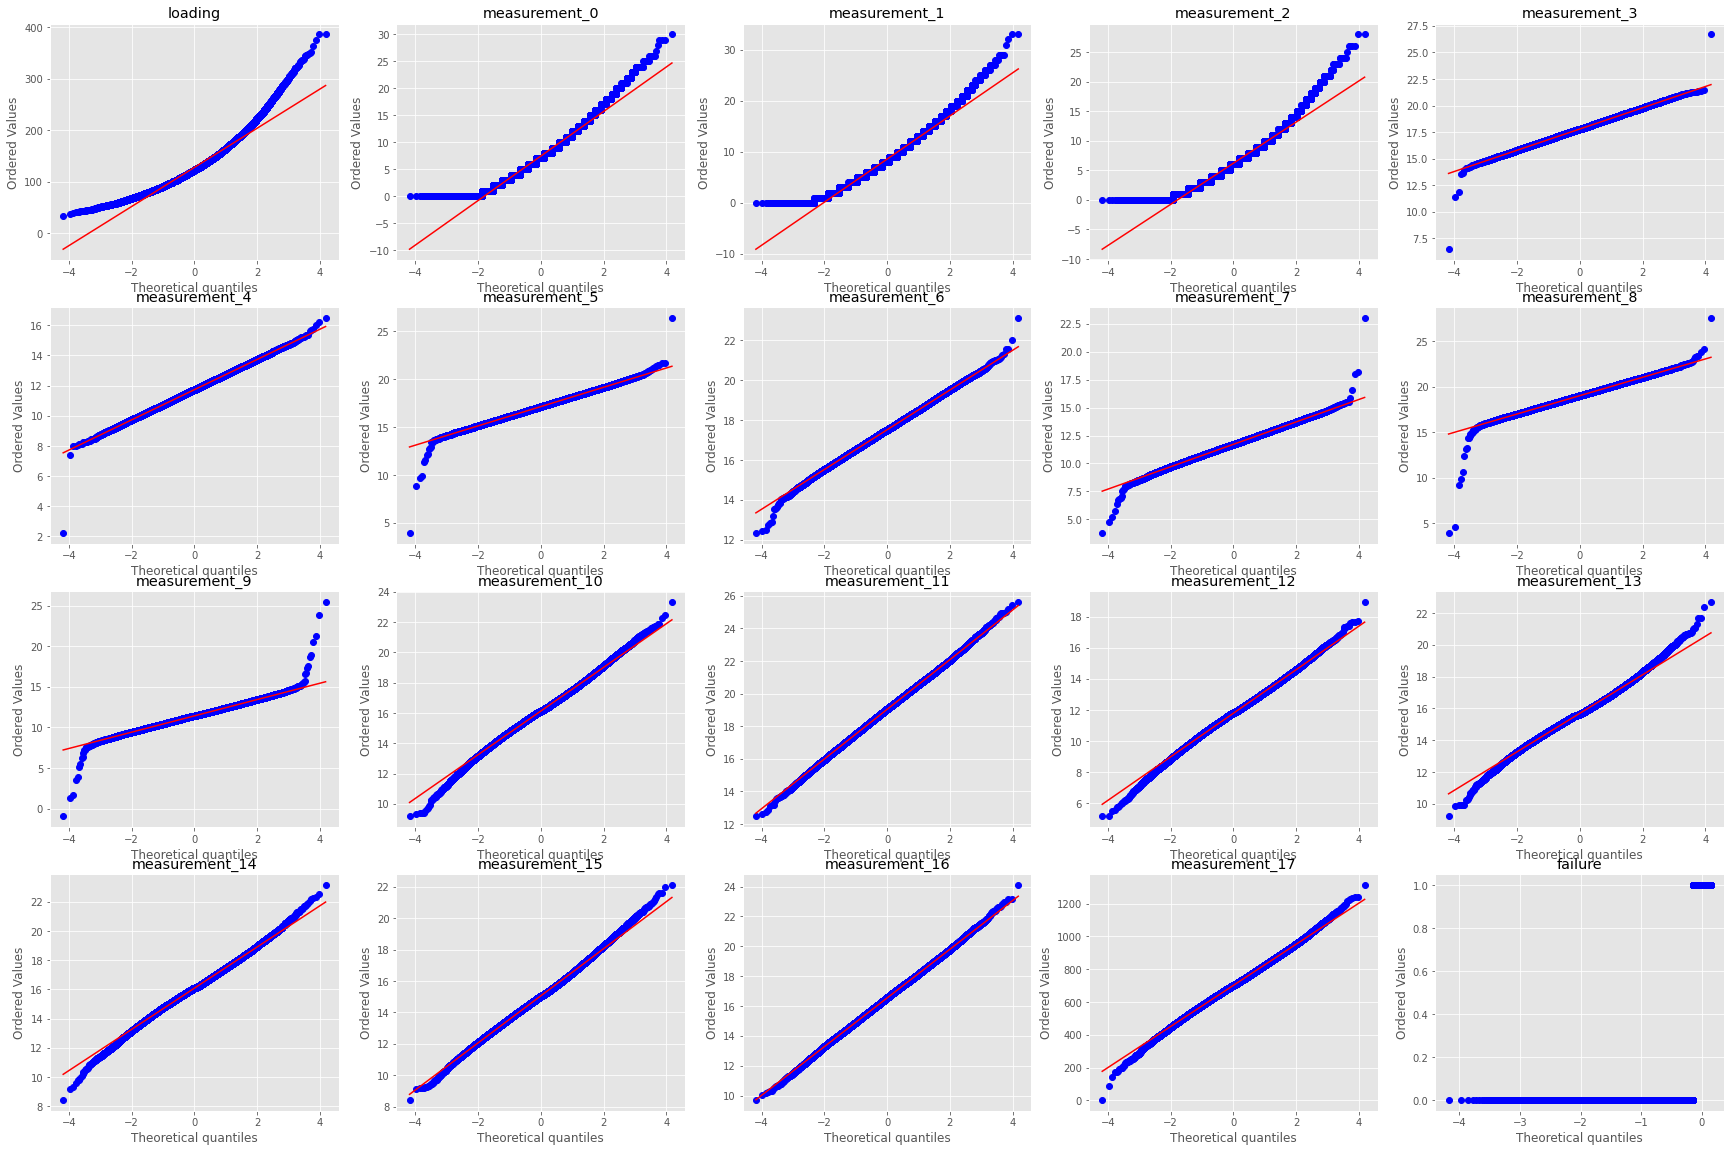

In [19]:
# fig, axes = plt.subplots(4, 5, figsize=(30, 20))

# for ax, col in zip(axes.ravel(), cont_feats):
#     stats.probplot(data[col], plot=ax)
#     ax.set_title(f'{col}')